In [44]:
import importlib
importlib.reload(cluster_util)
import cluster_util

# Notebook error analysis 

## Refining error types - Vectorization and clustering method selection


use a subset of the dedupped GitHub error dataset with ename == valueerror

### Clustering value errors

load tokenized error dataset, evalue_tokenized

In [1]:
import pandas as pd 
import cluster_util, config

df_mlerr_g_mlbugs_unique = pd.read_excel(config.path_github_error_analysis.joinpath("df_mlerr_g_mlbugs_filtered_dedup.xlsx"))
# df_mlerr_k_mlbugs_valueerr_unique = pd.read_excel(config.path_kaggle_cluster_valueerr)

df_mlerr_g_mlbugs_valueerr_unique = df_mlerr_g_mlbugs_unique[(df_mlerr_g_mlbugs_unique.ename=="valueerror")]
err_descs = df_mlerr_g_mlbugs_valueerr_unique['evalue_tokenized'].values.astype('U')

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


### 1 Vectorization
##### 1. tfidf
too high dimension

In [3]:
X_tfidf = cluster_util.vectorizer_tfidf(err_descs)
X_tfidf.shape

(1808, 3047)

##### 2. sentence transformers

https://github.com/UKPLab/sentence-transformers

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentence to vector, dimension -384

2 embeddings with different preprocessing

In [4]:
X_transformers = cluster_util.vectorizer_sentence2vec(err_descs)
X_transformers.shape

(1808, 384)

In [6]:
df_mlerr_g_mlbugs_valueerr_unique['evalue_tokenized_transformer'] = df_mlerr_g_mlbugs_valueerr_unique['evalue'].apply(cluster_util.preprocess_text_transformer)
err_descs1 = df_mlerr_g_mlbugs_valueerr_unique['evalue_tokenized_transformer'].values.astype('U')

X_transformers1 = cluster_util.vectorizer_sentence2vec(err_descs1)

##### 3. word embeddings - GloVe

Turn sentences to vectors via word embeddings by taking the mean/sum of all word embeddings of the sentence

using GloVe with dimension 200

In [2]:
import numpy as np

glove_vectors = cluster_util.load_glove("C:/Users/yirwa29/Downloads/Dataset-Nb/glove.6B/glove.6B.200d.txt")
X_glove = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])
X_glove.shape

Loaded 400000 word vectors from GloVe.


(1985, 200)

### 2. Clustering with vectorized error values


##### 1. tfidf

In [19]:
##PCA
n_components = cluster_util.select_pca_n_basedon_variance(X_tfidf)
X_tfidf_pca = cluster_util.pca(X_tfidf, n_components=n_components)

pca: 433 components can explain 80.04% variance of the data


In [45]:
## kmeans
K_range = range(2,100)
inertias = cluster_util.elbow_for_kmean(X_tfidf_pca, K_range = K_range)

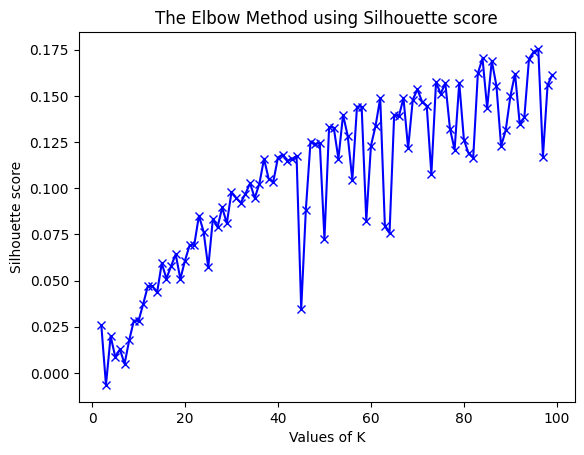

In [46]:
import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method using Silhouette score')
plt.show()

In [22]:
num_clusters = 80
res = cluster_util.cluster_kmeans(X_tfidf_pca, n_clusters=num_clusters)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_km_tfidf"] = res

In [18]:
## dbscan

In [23]:
eps_tfidf = cluster_util.epsilon_search_dbscan(X_tfidf_pca)
print(eps_tfidf)
res = cluster_util.cluster_dbscan(X_tfidf_pca, eps=eps_tfidf, min_samples=2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_dbscan_tfidf"] = res

0.7069184405392713
Estimated no. of clusters: 197
Estimated no. of noise points: 760


In [22]:
## OPTICS

In [25]:
res = cluster_util.cluster_optics(X_tfidf_pca, min_samples = 2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_optics_tfidf"] = res

Estimated no. of clusters: 330
Estimated no. of noise points: 899


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [ ]:
# hierarchical - AgglomerativeClustering

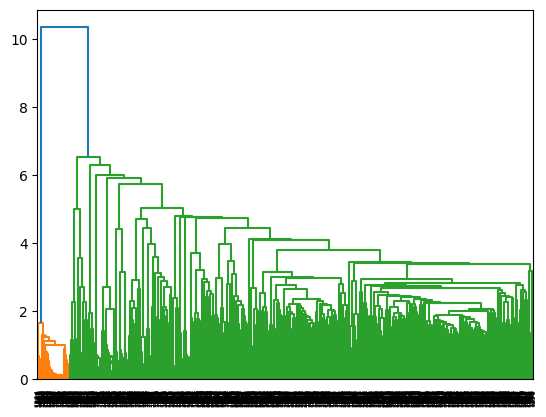

In [50]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

Dendrogram = shc.dendrogram((shc.linkage(X_tfidf_pca, method ='ward')))

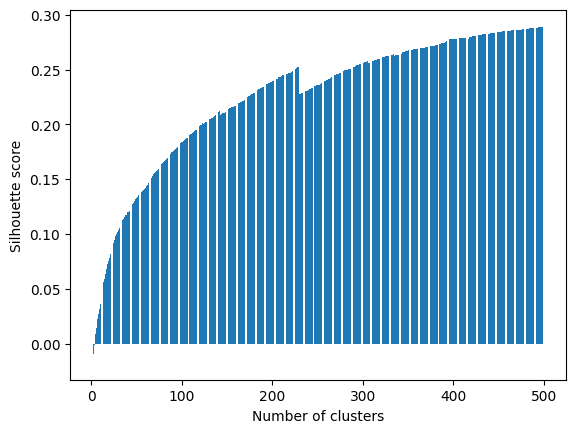

In [87]:
import matplotlib.pyplot as plt

ks = range(2,500)
silhouette_scores_tfidf = []
for k in ks:
    model = AgglomerativeClustering(n_clusters = k, linkage="ward")
    model.fit(X_tfidf_pca) # model.fit_predict(X_tfidf_pca)
    silhouette_scores_tfidf.append(cluster_util.eval_cluster_silhouette(X_tfidf_pca, model.labels_))

# plot
plt.bar(ks, silhouette_scores_tfidf)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

##### 2. sentence transformers

In [26]:
##PCA
n_components = cluster_util.select_pca_n_basedon_variance(X_transformers)
X_transformers_pca = cluster_util.pca(X_transformers, n_components=n_components)

pca: 96 components can explain 80.16% variance of the data


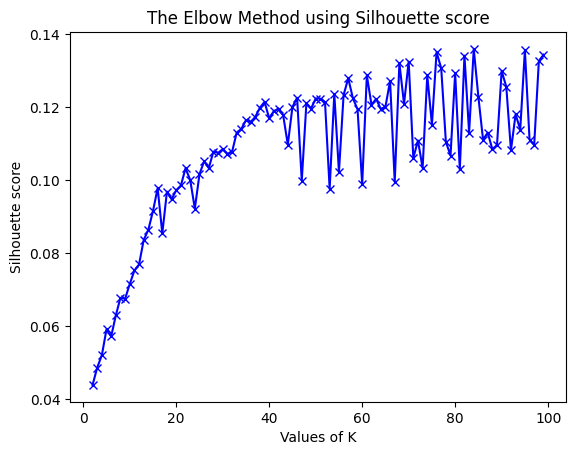

In [47]:
## kmeans
K_range = range(2,100)
inertias = cluster_util.elbow_for_kmean(X_transformers_pca, K_range = K_range) # X_transformers1

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method using Silhouette score')
plt.show()

In [29]:
num_clusters = 40
res = cluster_util.cluster_kmeans(X_transformers_pca, n_clusters=num_clusters)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_km_transformers"] = res

In [32]:
## dbscan

In [30]:
eps_transformers = cluster_util.epsilon_search_dbscan(X_transformers_pca)
print(eps_transformers)
res = cluster_util.cluster_dbscan(X_transformers_pca, eps=eps_transformers, min_samples=2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_dbscan_transformers"] = res

0.7433380154692085
Estimated no. of clusters: 123
Estimated no. of noise points: 404


In [39]:
## OPTICS

In [31]:
res = cluster_util.cluster_optics(X_transformers_pca, min_samples = 2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_optics_transformers"] = res

Estimated no. of clusters: 326
Estimated no. of noise points: 883


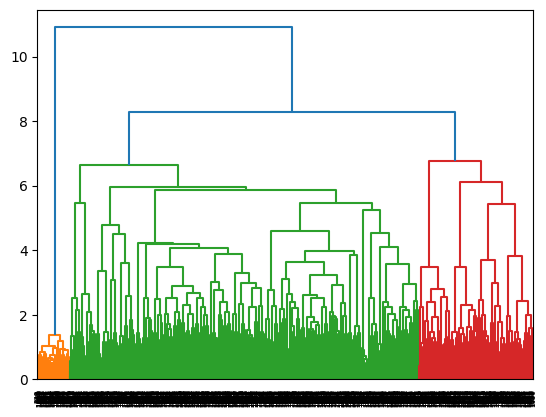

In [53]:
# hierarchical - AgglomerativeClustering
Dendrogram = shc.dendrogram((shc.linkage(X_transformers_pca, method ='ward')))

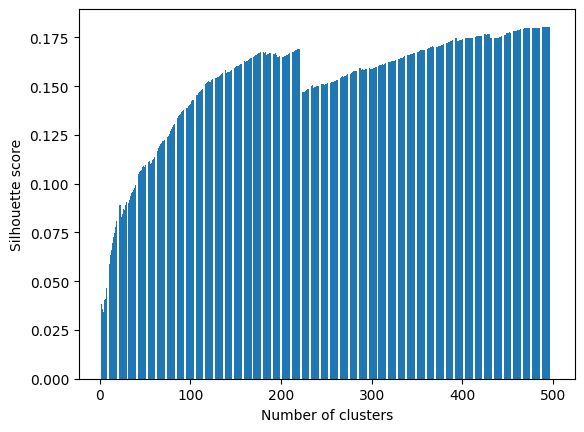

In [88]:
import matplotlib.pyplot as plt

ks = range(2,500)
silhouette_scores_transformers = []
for k in ks:
    model = AgglomerativeClustering(n_clusters = k, linkage="ward")
    model.fit(X_transformers_pca) # model.fit_predict(X_transformers_pca)
    silhouette_scores_transformers.append(cluster_util.eval_cluster_silhouette(X_transformers_pca, model.labels_))

# plot
plt.bar(ks, silhouette_scores_transformers)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

##### 3. word embeddings - GloVe

In [3]:
##PCA
n_components = cluster_util.select_pca_n_basedon_variance(X_glove)
X_glove_pca = cluster_util.pca(X_glove, n_components=n_components)

pca: 52 components can explain 80.11% variance of the data


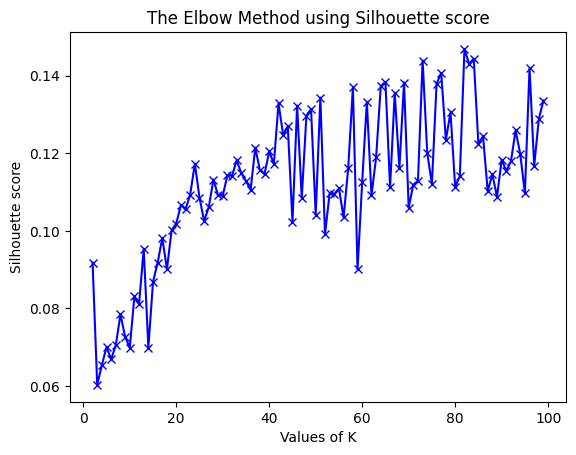

In [4]:
## kmeans
K_range = range(2,100)
inertias = cluster_util.elbow_for_kmean(X_glove_pca, K_range = K_range)

import matplotlib.pyplot as plt

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method using Silhouette score')
plt.show()

In [5]:
num_clusters = 46
res = cluster_util.cluster_kmeans(X_glove_pca, n_clusters=num_clusters)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_km_glove"] = res

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_20888\557448736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_km_glove"] = res


In [6]:
cluster_util.eval_cluster_silhouette(X_glove_pca, df_mlerr_g_mlbugs_valueerr_unique['cluster_km_glove'])

0.0986721057320393

In [7]:
## dbscan

In [8]:
eps_glove = cluster_util.epsilon_search_dbscan(X_glove_pca)
print(eps_glove)
res = cluster_util.cluster_dbscan(X_glove_pca, eps=eps_glove, min_samples=2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_dbscan_glove"] = res

0.9794198838688931
Estimated no. of clusters: 138
Estimated no. of noise points: 1289


C:\Users\yirwa29\AppData\Local\Temp\ipykernel_20888\3559159733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_dbscan_glove"] = res


In [9]:
cluster_util.eval_cluster_silhouette(X_glove_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_glove']!=-1],
                                     df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_glove']!=-1, 'cluster_dbscan_glove'])

0.5277033171869663

In [10]:
## OPTICS

In [11]:
res = cluster_util.cluster_optics(X_glove_pca, min_samples = 2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_optics_glove"] = res

Estimated no. of clusters: 306
Estimated no. of noise points: 1115


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\yirwa29\AppData\Local\Temp\ipykernel_20888\1546380328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_optics_glove"] = res


In [12]:
cluster_util.eval_cluster_silhouette(X_glove_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_glove']!=-1],
                                     df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_glove']!=-1, 'cluster_optics_glove'])

0.5011484242120253

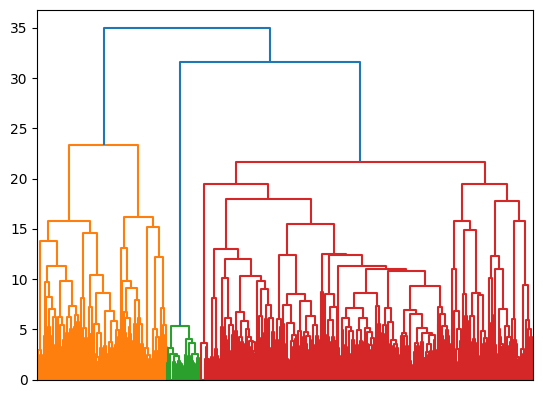

In [13]:
# hierarchical - AgglomerativeClustering
from scipy.cluster import hierarchy as shc

Dendrogram = shc.dendrogram((shc.linkage(X_glove_pca, method ='ward')), no_labels=True)

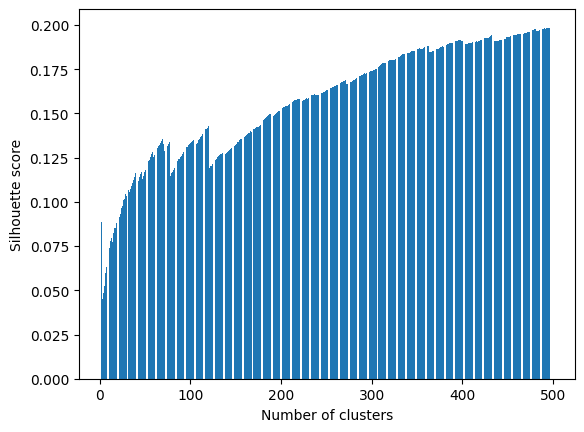

In [14]:
import matplotlib.pyplot as plt

ks = range(2,500)
silhouette_scores_glove = []
for k in ks:
    model = cluster_util.cluster_agglomerative(X_glove_pca, n_clusters=k)
    silhouette_scores_glove.append(cluster_util.eval_cluster_silhouette(X_glove_pca, model.labels_))

# plot
plt.bar(ks, silhouette_scores_glove)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [15]:
# outputs the structure of the tree
model = cluster_util.cluster_agglomerative(X_glove_pca, n_clusters=4) #model.labels_
root = cluster_util.aggcluster_to_tree(model)

In [16]:
from bigtree import levelorder_iter

res_nodes = []

for node in levelorder_iter(root):
    if len(list(node.leaves)) in range(20,60):
        res_nodes.append(node)

In [27]:
import random
#take the last one for example
res_names = [leave_node.node_name-1 for leave_node in res_nodes[random.randint(0,len(res_nodes))].leaves]
# see what are they
for i in df_mlerr_g_mlbugs_valueerr_unique.iloc[res_names].evalue:
    print("==>",i)

==> 'u' and 'v' must be of shape 'Grid(x,y)'
==> If only `x` is given as input, it has to be of shape (2, N) or (N, 2), provided shape was (100, 3)
==> Input size mismatch, for <F: (64, 128)x(64, 128) FourierTransform NUMPY operator with dtype=complex32>, got (1024, 1024)
==> matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)
==> matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
==> c of shape (48,) not acceptable as a color sequence for x with size 100, y with size 100
==> 'c' argument has 135 elements, which is not acceptable for use with 'x' with size 116, 'y' with size 116.
==> 'c' argument has 1554 elements, which is inconsistent with 'x' and 'y' with size 11314.
==> Output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: [[[[-0.03505491  0.14596471  0.064     ]
==> Incompatible shapes for gemv 

In [28]:
df_mlerr_g_mlbugs_valueerr_unique.iloc[res_names].evalue_tokenized

2515                                 u v must shape grid x
11140            if x given input shape n n provided shape
4196     input size mismatch f x fouriertransform numpy...
12129    matmul input operand mismatch core dimension g...
12880    matmul input operand enough dimensions gufunc ...
12157        c shape acceptable color sequence x size size
11537       c argument elements acceptable use x size size
12087              c argument elements inconsistent x size
1261         output generator tuple x sampleweight x found
5970       incompatible shapes gemv beta alpha dot a x a x
5539                               input passed argument x
6857          zeromethod wilcox pratt work x zero elements
5685                 no feature x meets variance threshold
10050    x contains constant adding constant trend c al...
12767                          negative dimensions allowed
6036     negative values data passed multinomialnb input x
7612                             input x must non negati

In [18]:
nk = 294
# print(silhouette_scores_tfidf[nk-2])
# print(silhouette_scores_transformers[nk-2])
print(silhouette_scores_glove[nk-2])

0.1729645782116085


### 3. Evaluate vectorization and clustering methods

In [39]:
df_mlerr_g_mlbugs_valueerr_unique.columns

Index(['fname', 'eid', 'ename', 'evalue', 'traceback', 'ename_mapped',
       'imports', 'lib_alias', 'exp_mllib', 'exp_mllib_extracted',
       'python_version', 'evalue_tokenized', 'hash_evalue_tokenized',
       'evalue_tokenized_transformer', 'cluster_km_tfidf',
       'cluster_dbscan_tfidf', 'cluster_optics_tfidf',
       'cluster_km_transformers', 'cluster_dbscan_transformers',
       'cluster_optics_transformers', 'cluster_km_glove',
       'cluster_dbscan_glove', 'cluster_optics_glove'],
      dtype='object')

In [41]:
arr_eval = np.zeros((3,3))
name_cols = ['tfidf','word2vec','transformer'] #,'transformer1'
name_rows = ['kmeans','dbscan','optics']

#ss_km_tfidf
arr_eval[0,0] = cluster_util.eval_cluster_silhouette(X_tfidf_pca, df_mlerr_g_mlbugs_valueerr_unique['cluster_km_tfidf'])
#ss_km_glove
arr_eval[0,1] = cluster_util.eval_cluster_silhouette(X_glove_pca, df_mlerr_g_mlbugs_valueerr_unique['cluster_km_glove'])
#ss_km_transformers
arr_eval[0,2] = cluster_util.eval_cluster_silhouette(X_transformers_pca, df_mlerr_g_mlbugs_valueerr_unique['cluster_km_transformers'])
#ss_km_transformers1
# arr_eval[0,3] = cluster_util.eval_cluster_silhouette(X_transformers1, df2_err_ename['cluster_km_transformers1'])

#ss_dbscan_tfidf
arr_eval[1,0] = cluster_util.eval_cluster_silhouette(X_tfidf_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_tfidf']!=-1], 
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_tfidf']!=-1, 'cluster_dbscan_tfidf'])
#ss_dbscan_glove
arr_eval[1,1] = cluster_util.eval_cluster_silhouette(X_glove_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_glove']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_glove']!=-1, 'cluster_dbscan_glove'])
#ss_dbscan_transformers
arr_eval[1,2] = cluster_util.eval_cluster_silhouette(X_transformers_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_transformers']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_transformers']!=-1, 'cluster_dbscan_transformers'])
#ss_dbscan_transformers1
# arr_eval[1,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_dbscan_transformers1']!=-1],
#                                         df2_err_ename.loc[df2_err_ename['cluster_dbscan_transformers1']!=-1, 'cluster_dbscan_transformers1'])
#ss_optics_tfidf
arr_eval[2,0] = cluster_util.eval_cluster_silhouette(X_tfidf_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_tfidf']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_tfidf']!=-1, 'cluster_optics_tfidf'])
#ss_optics_glove
arr_eval[2,1] = cluster_util.eval_cluster_silhouette(X_glove_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_glove']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_glove']!=-1, 'cluster_optics_glove'])
#ss_optics_transformers
arr_eval[2,2] = cluster_util.eval_cluster_silhouette(X_transformers_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_transformers']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_transformers']!=-1, 'cluster_optics_transformers'])
#ss_optics_transformers1
# arr_eval[2,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_optics_transformers1']!=-1],
#                                         df2_err_ename.loc[df2_err_ename['cluster_optics_transformers1']!=-1, 'cluster_optics_transformers1'])

In [42]:
df_eval = pd.DataFrame(arr_eval, index=name_rows, columns=name_cols)
df_eval

,tfidf,word2vec,transformer
kmeans,0.157953,0.107939,0.109920
dbscan,0.350171,0.286836,0.029276
optics,0.463592,0.442552,0.345431


selected optimal clustering method + wordembeddings = optics + word2vec(GloVe)